In [1]:
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import os
import json

In [2]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [3]:
from huggingface_hub import login
login("")

In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Create a custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True, # CLS EOS
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',   # Padding for smaller sentences
            truncation=True,        # Cut down long sentences
            return_attention_mask=True,  # Tells which words are padded
            return_tensors='pt'    # return pytorch tensors
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [7]:
## Loading IMDB dataset
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [40]:
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split

# Load IMDb dataset
imdb = load_dataset("imdb")


In [52]:
# Convert train and test splits to pandas DataFrames
train_df = pd.DataFrame(imdb["train"])
test_df = pd.DataFrame(imdb["test"])
test_df = test_df.reset_index(drop=True)


# Combine full dataset
full_df = pd.concat([train_df, test_df], ignore_index=True)

# Sample 7000 rows randomly
sampled_df = full_df.sample(n=4000, random_state=42).reset_index(drop=True)

# Split into train (80%) and test (20%)
train_df, test_df = train_test_split(sampled_df, test_size=0.2, random_state=42, stratify=sampled_df["label"])

# Reset index to prevent KeyErrors
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [18]:
# Function to create a manual dataset
def create_manual_dataset():
    # Positive reviews
    positive_reviews = [
        "This movie was fantastic! I really enjoyed every minute of it.",
        "I loved the performances in this film. The actors were amazing.",
        "A masterpiece of modern cinema. I was captivated throughout.",
        "The director did an excellent job with limited resources.",
        "The screenplay was well-written and the direction was superb.",
        "This movie exceeded all my expectations. Truly brilliant.",
        "A beautiful story told with care and precision. Loved it!",
        "The cinematography alone makes this film worth watching.",
        "One of the best films I've seen in recent years.",
        "I was on the edge of my seat the entire time. Great thriller!",
        "The plot development was excellent, with surprising twists.",
        "The movie had heart and soul. I was moved to tears.",
        "Brilliantly acted and beautifully shot. A must-see film.",
        "This film deserves all the awards. Simply outstanding.",
        "I can't stop thinking about this movie. It's that good.",
        "A perfect blend of humor and drama. Well balanced.",
        "The score complemented the visuals perfectly. Incredible experience.",
        "I've watched it three times already and still love it.",
        "This film will go down as a classic. Absolutely wonderful.",
        "Powerful storytelling and emotional depth. A triumph.",
        "Ingenious plot and excellent character development.",
        "The dialogue was sharp, witty, and memorable.",
        "A refreshing take on the genre. Very original.",
        "I recommend this movie to everyone. It's universally appealing.",
        "The pacing was perfect. Not a dull moment throughout.",
        "The ensemble cast delivered stellar performances.",
        "This movie will stay with you long after it ends.",
        "A creative masterpiece that pushes boundaries.",
        "Enchanting and magical from start to finish.",
        "The perfect movie for a Friday night. Thoroughly enjoyed it.",
        "Every scene was meticulously crafted. Visually stunning.",
        "The character arcs were satisfying and well-developed.",
        "I couldn't have asked for a better adaptation of the book.",
        "This film exceeded the hype. Absolutely fantastic.",
        "The action sequences were breathtaking and innovative.",
        "A thought-provoking film that challenges conventions.",
        "The attention to detail in this movie was remarkable.",
        "Impressive on all fronts - acting, directing, and writing.",
        "This movie deserves multiple viewings to appreciate fully.",
        "A unique vision brought to life beautifully on screen."
    ]

    # Negative reviews
    negative_reviews = [
        "What a terrible waste of time. I hated this movie completely.",
        "The special effects were incredible, but the story was lacking.",
        "This is the worst film I've seen all year. Absolutely terrible.",
        "Boring, predictable, and poorly acted. Don't waste your money.",
        "I fell asleep halfway through. So boring and pointless.",
        "I couldn't connect with any of the characters. Very disappointing.",
        "The plot had too many holes to be enjoyable.",
        "I regret spending money on this awful movie.",
        "The dialogue was stilted and unrealistic. Poor writing overall.",
        "Mediocre at best. Nothing special to see here.",
        "This movie was a complete disaster from start to finish.",
        "The pacing was off and the story made no sense.",
        "Overacted and underwritten. A complete mess.",
        "Too long and too boring. I checked my watch constantly.",
        "The director should be ashamed of this terrible film.",
        "A waste of talented actors. The script was garbage.",
        "I've seen student films with better production value.",
        "The ending was so disappointing it ruined the entire movie.",
        "Pretentious and self-indulgent. Empty artistic posturing.",
        "Too many clichés to count. Nothing original here.",
        "This film is the definition of style over substance.",
        "The characters were one-dimensional and unlikable.",
        "Confusing plot with no payoff. Completely unsatisfying.",
        "I want those two hours of my life back. Terrible.",
        "It failed on every level - writing, acting, and directing.",
        "A big-budget disaster. All flash and no heart.",
        "This movie thinks it's smarter than it actually is.",
        "Derivative and unimaginative. I've seen it all before.",
        "The cinematography was the only decent thing about it.",
        "I walked out of the theater halfway through.",
        "This film doesn't know what it wants to be.",
        "Poorly edited with jarring scene transitions.",
        "The worst entry in what was once a great franchise.",
        "Illogical character decisions ruined the plot.",
        "This movie completely missed the point of the source material.",
        "Tries too hard to be edgy and fails miserably.",
        "Hollow characters in a meaningless story. Avoid.",
        "The CGI looked fake and took me out of the experience.",
        "This story has been told better countless times before.",
        "A soulless cash grab with no artistic merit whatsoever."
    ]

    # Mixed reviews (more nuanced)
    mixed_reviews = [
        "Good performances but the script needed work.",
        "Beautiful visuals but the story was somewhat lacking.",
        "An interesting concept poorly executed.",
        "Started strong but fell apart in the third act.",
        "Some great moments but inconsistent overall.",
        "The lead actor was amazing but everyone else seemed lost.",
        "Worth watching for the cinematography alone, despite the weak plot.",
        "A decent film that could have been great with better editing.",
        "Entertaining but ultimately forgettable.",
        "An ambitious failure that at least tried something new.",
        "The first half was riveting, but it lost its way.",
        "Solid performances couldn't save the mediocre script.",
        "A flawed gem with moments of brilliance.",
        "Not as good as the director's previous work, but still worthwhile.",
        "Good ideas poorly implemented. A disappointment.",
        "Technical brilliance marred by narrative shortcomings.",
        "Worth watching once, but wouldn't recommend buying it.",
        "Not as bad as critics say, but not great either.",
        "Had potential but failed to deliver on its promises.",
        "The director's vision was clear but the execution was lacking."
    ]

    # Combine all reviews
    all_texts = positive_reviews + negative_reviews + mixed_reviews

    # Create labels (1 for positive, 0 for negative, randomly assign mixed as 0 or 1)
    labels = [1] * len(positive_reviews) + [0] * len(negative_reviews)

    # For mixed reviews, randomly assign 0 or 1
    mixed_labels = [random.randint(0, 1) for _ in range(len(mixed_reviews))]
    labels += mixed_labels

    # Shuffle the data while maintaining label correspondence
    combined = list(zip(all_texts, labels))
    random.shuffle(combined)
    all_texts, labels = zip(*combined)

    return list(all_texts), list(labels)

In [53]:
# Training function
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=4, model_dir='model_checkpoints'):
    # Create directory for saving model
    os.makedirs(model_dir, exist_ok=True)

    best_val_loss = float('inf')
    patience = 7
    counter = 0

    # Lists to store metrics
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Dictionary to store training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Training
        model.train()
        train_loss = 0
        train_progress_bar = tqdm(train_dataloader, desc="Training")

        for batch in train_progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass and optimization
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            # Update metrics
            train_loss += loss.item()
            train_progress_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        history['train_loss'].append(avg_train_loss)
        print(f"Average training loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        predictions = []
        true_labels = []

        with torch.no_grad():
            val_progress_bar = tqdm(val_dataloader, desc="Validation")

            for batch in val_progress_bar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                val_loss += loss.item()

                # Convert logits to predictions
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                predictions.extend(preds)
                true_labels.extend(labels.cpu().numpy())

                val_progress_bar.set_postfix({'loss': loss.item()})

        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        history['val_loss'].append(avg_val_loss)

        # Calculate metrics
        accuracy = accuracy_score(true_labels, predictions)
        val_accuracies.append(accuracy)
        history['val_accuracy'].append(accuracy)

        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, predictions, average='binary', zero_division=0
        )

        history['val_precision'].append(precision)
        history['val_recall'].append(recall)
        history['val_f1'].append(f1)

        print(f"Validation - Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        checkpoint_path = os.path.join(model_dir, f'checkpoint_epoch_{epoch+1}.pt')
        save_model(model, tokenizer, checkpoint_path, history, epoch+1)
        print(f"Saved checkpoint for epoch {epoch+1}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            best_model_path = os.path.join(model_dir, 'best_model.pt')
            save_model(model, tokenizer, best_model_path, history, epoch+1, is_best=True)
            print("Saved best model!")
        else:
            counter += 1
            print(f"EarlyStopping counter: {counter} out of {patience}")
            if counter >= patience:
                print("Early stopping")
                break

    # Save final model
    final_model_path = os.path.join(model_dir, 'final_model.pt')
    save_model(model, tokenizer, final_model_path, history, epochs)
    print(f"Saved final model after {epochs} epochs")

    with open(os.path.join(model_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f)

    return train_losses, val_losses, val_accuracies, history

In [10]:
# Function to save model
def save_model(model, tokenizer, path, history=None, epoch=None, is_best=False):
    os.makedirs(os.path.dirname(path), exist_ok=True)

    torch.save({
        'model_state_dict': model.state_dict(),
        'epoch': epoch,
        'is_best': is_best,
        'history': history
    }, path)

    tokenizer_dir = os.path.join(os.path.dirname(path), 'tokenizer')
    if not os.path.exists(tokenizer_dir):
        os.makedirs(tokenizer_dir)
        tokenizer.save_pretrained(tokenizer_dir)

    print(f"Model saved to {path}")

In [11]:
# Function to load model
def load_model(model_path, tokenizer_dir=None):
    if tokenizer_dir is None:
        tokenizer_dir = os.path.join(os.path.dirname(model_path), 'tokenizer')

    tokenizer = BertTokenizer.from_pretrained(tokenizer_dir)

    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    )

    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)

    print(f"Loaded model from {model_path}")
    if 'epoch' in checkpoint:
        print(f"Model was trained for {checkpoint['epoch']} epochs")
    if 'is_best' in checkpoint and checkpoint['is_best']:
        print("This is the best model based on validation loss")

    return model, tokenizer, checkpoint

In [12]:
# Evaluation function
def evaluate_model(model, test_dataloader):
    model.eval()
    predictions = []
    true_labels = []
    test_loss = 0

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            test_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='binary', zero_division=0
    )

    cm = confusion_matrix(true_labels, predictions)

    eval_results = {
        'test_loss': avg_test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm.tolist(),
        'predictions': predictions,
        'true_labels': true_labels
    }

    return eval_results

In [13]:
# Visualization functions
def plot_training_curves(history, save_path='plots'):
    """Plot training and validation curves"""
    os.makedirs(save_path, exist_ok=True)

    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Accuracy', color='green')
    plt.plot(history['val_precision'], label='Precision', color='blue')
    plt.plot(history['val_recall'], label='Recall', color='red')
    plt.plot(history['val_f1'], label='F1', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Metrics')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'training_curves.png'))
    plt.show()

In [14]:
def plot_confusion_matrix(cm, save_path='plots'):
    """Plot confusion matrix"""
    os.makedirs(save_path, exist_ok=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(save_path, 'confusion_matrix.png'))
    plt.show()

In [15]:
# The most important function or task
def predict_sentiment(model, tokenizer, texts, max_length=128):
    model.eval()
    predictions = []
    confidences = []

    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(
                text,
                add_special_tokens=True,
                max_length=max_length,
                return_token_type_ids=False,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            ).to(device)

            outputs = model(**inputs)
            logits = outputs.logits

            probs = torch.nn.functional.softmax(logits, dim=1)

            prediction = torch.argmax(probs, dim=1).item()
            confidence = probs[0][prediction].item()

            predictions.append(prediction)
            confidences.append(confidence)

    sentiments = ["Negative" if pred == 0 else "Positive" for pred in predictions]

    return list(zip(sentiments, confidences))

In [36]:
 # print("Creating dataset...")
    # texts, labels = create_manual_dataset()

    # print("Splitting data...")
    # train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    #     train_df['text'], train_df['labels'], test_size=0.3, random_state=42
    # )
    # val_texts, test_texts, val_labels, test_labels = train_test_split(
    #     test_df['text'], test_df['labels'], test_size=0.5, random_state=42
    # )

print("Creating dataset...")
texts, labels = create_manual_dataset()

print("Splitting data...")
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        texts, labels, test_size=0.3, random_state=42
    )
val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels, test_size=0.5, random_state=42
    )

Creating dataset...
Splitting data...


In [55]:
def main():
    global tokenizer  # Make tokenizer accessible to save_model

    os.makedirs('model_checkpoints', exist_ok=True)
    os.makedirs('plots', exist_ok=True)

    # print("Creating dataset...")
    # texts, labels = create_manual_dataset()

    print("Splitting data...")
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        train_df['text'], train_df['label'], test_size=0.3, random_state=42
    )
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        test_df['text'], test_df['label'], test_size=0.5, random_state=42
    )

    train_texts = train_texts.reset_index(drop=True)
    train_labels = train_labels.reset_index(drop=True)

    val_texts = val_texts.reset_index(drop=True)
    val_labels = val_labels.reset_index(drop=True)

    test_texts = test_texts.reset_index(drop=True)
    temp_labels = temp_labels.reset_index(drop=True)  # since you paired test_texts with temp_labels


    print(f"Train size: {len(train_texts)}, Validation size: {len(val_texts)}, Test size: {len(test_texts)}")

    # Initialize tokenizer
    print("Loading tokenizer...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Create datasets
    print("Creating datasets...")
    # Reset indices to prevent KeyErrors during .iloc access
    train_texts = train_texts.reset_index(drop=True)
    train_labels = train_labels.reset_index(drop=True)
    val_texts = val_texts.reset_index(drop=True)
    val_labels = val_labels.reset_index(drop=True)
    test_texts = test_texts.reset_index(drop=True)
    test_labels = test_labels.reset_index(drop=True)

    # Create datasets
    print("Creating datasets...")
    train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
    val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)
    test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

    train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
    val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)
    test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

    # Create data loaders
    batch_size = 128
    train_dataloader = DataLoader(
        train_dataset,
        sampler=RandomSampler(train_dataset),
        batch_size=batch_size
    )
    val_dataloader = DataLoader(
        val_dataset,
        sampler=SequentialSampler(val_dataset),
        batch_size=batch_size
    )
    test_dataloader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=batch_size
    )

    # Initialize model
    print("Loading model...")
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,  # Binary classification
        output_attentions=False,
        output_hidden_states=False
    )
    model = model.to(device)

    # Initialize optimizer and scheduler
    epochs = 10
    optimizer = torch.optim.AdamW(model.parameters(), lr= 1e-5, eps=1e-8)

    # Create scheduler
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Train model
    print("Training model...")
    train_losses, val_losses, val_accuracies, history = train_model(
        model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=epochs
    )

    # Load best model for evaluation
    print("Loading best model for evaluation...")
    model, tokenizer, checkpoint = load_model('model_checkpoints/best_model.pt')

    # Evaluate model
    print("Evaluating model...")
    eval_results = evaluate_model(model, test_dataloader)

    print("\nTest Results:")
    print(f"Test Loss: {eval_results['test_loss']:.4f}")
    print(f"Accuracy: {eval_results['accuracy']:.4f}")
    print(f"Precision: {eval_results['precision']:.4f}")
    print(f"Recall: {eval_results['recall']:.4f}")
    print(f"F1 Score: {eval_results['f1']:.4f}")

    # Save evaluation results
    with open('model_checkpoints/evaluation_results.json', 'w') as f:
        # Convert numpy values to Python native types for JSON serialization
        serializable_results = {
            k: v if not isinstance(v, np.ndarray) and not isinstance(v, list) or k in ['confusion_matrix']
            else v.tolist() if isinstance(v, np.ndarray)
            else [float(item) for item in v]
            for k, v in eval_results.items()
        }
        json.dump(serializable_results, f, indent=4)

    # Plot results
    plot_training_curves(history)
    plot_confusion_matrix(np.array(eval_results['confusion_matrix']))

    # Example inference
    print("\nExample Inference:")
    example_texts = [
    "I am happy today.",
    "This is so sad.",
    "I’m really scared.",
    "That made me angry.",
    "Although I smiled, deep down I felt completely empty.",
    "I didn’t expect it, but I’m incredibly proud of myself.",
    "My hands were shaking as I waited for the results.",
    "I’m not unhappy, but I wouldn’t say I’m thrilled either.",
    "I can’t deny that I didn’t feel a bit of joy.",
    "She wasn’t exactly angry, yet something about her silence screamed frustration."
    ]


    results = predict_sentiment(model, tokenizer, example_texts)

    for i, (text, (sentiment, confidence)) in enumerate(zip(example_texts, results)):
        print(f"Example {i+1}: {text}")
        print(f"Predicted sentiment: {sentiment} (confidence: {confidence:.4f})\n")

    # Save model in format for easy reloading
    model_dir = 'sentiment_analysis_model'
    os.makedirs(model_dir, exist_ok=True)
    model.save_pretrained(model_dir)
    tokenizer.save_pretrained(model_dir)

    # Save a config file with model information
    config = {
        'model_type': 'bert-base-uncased',
        'num_labels': 2,
        'max_length': 64,
        'labels': {
            '0': 'Negative',
            '1': 'Positive'
        },
        'performance': {
            'accuracy': float(eval_results['accuracy']),
            'f1': float(eval_results['f1'])
        },
        'training_completed': True
    }

    with open(os.path.join(model_dir, 'model_config.json'), 'w') as f:
        json.dump(config, f, indent=4)

    print(f"\nModel, tokenizer, and config saved to {model_dir}")
    print("To use this model later, you can load it with:")
    print("model = BertForSequenceClassification.from_pretrained('sentiment_analysis_model')")
    print("tokenizer = BertTokenizer.from_pretrained('sentiment_analysis_model')")

Splitting data...
Train size: 2240, Validation size: 400, Test size: 400
Loading tokenizer...
Creating datasets...
Creating datasets...
Loading model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...

Epoch 1/10


Training: 100%|██████████| 18/18 [00:57<00:00,  3.18s/it, loss=0.625]


Average training loss: 0.6672


Validation: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it, loss=0.571]


Validation - Loss: 0.6148, Accuracy: 0.6775
Precision: 0.6185, Recall: 0.8653, F1: 0.7214
Model saved to model_checkpoints/checkpoint_epoch_1.pt
Saved checkpoint for epoch 1
Model saved to model_checkpoints/best_model.pt
Saved best model!

Epoch 2/10


Training: 100%|██████████| 18/18 [00:56<00:00,  3.15s/it, loss=0.529]


Average training loss: 0.5567


Validation: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it, loss=0.52]


Validation - Loss: 0.4987, Accuracy: 0.8000
Precision: 0.7653, Recall: 0.8446, F1: 0.8030
Model saved to model_checkpoints/checkpoint_epoch_2.pt
Saved checkpoint for epoch 2
Model saved to model_checkpoints/best_model.pt
Saved best model!

Epoch 3/10


Training: 100%|██████████| 18/18 [00:56<00:00,  3.14s/it, loss=0.408]


Average training loss: 0.4384


Validation: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it, loss=0.472]


Validation - Loss: 0.4399, Accuracy: 0.8025
Precision: 0.7794, Recall: 0.8238, F1: 0.8010
Model saved to model_checkpoints/checkpoint_epoch_3.pt
Saved checkpoint for epoch 3
Model saved to model_checkpoints/best_model.pt
Saved best model!

Epoch 4/10


Training: 100%|██████████| 18/18 [00:56<00:00,  3.14s/it, loss=0.356]


Average training loss: 0.3662


Validation: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it, loss=0.502]


Validation - Loss: 0.4338, Accuracy: 0.8050
Precision: 0.7674, Recall: 0.8549, F1: 0.8088
Model saved to model_checkpoints/checkpoint_epoch_4.pt
Saved checkpoint for epoch 4
Model saved to model_checkpoints/best_model.pt
Saved best model!

Epoch 5/10


Training: 100%|██████████| 18/18 [00:56<00:00,  3.16s/it, loss=0.247]


Average training loss: 0.3125


Validation: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it, loss=0.53]


Validation - Loss: 0.4319, Accuracy: 0.8225
Precision: 0.7933, Recall: 0.8549, F1: 0.8229
Model saved to model_checkpoints/checkpoint_epoch_5.pt
Saved checkpoint for epoch 5
Model saved to model_checkpoints/best_model.pt
Saved best model!

Epoch 6/10


Training: 100%|██████████| 18/18 [00:55<00:00,  3.10s/it, loss=0.336]


Average training loss: 0.2755


Validation: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it, loss=0.532]


Validation - Loss: 0.4323, Accuracy: 0.8200
Precision: 0.8418, Recall: 0.7720, F1: 0.8054
Model saved to model_checkpoints/checkpoint_epoch_6.pt
Saved checkpoint for epoch 6
EarlyStopping counter: 1 out of 7

Epoch 7/10


Training: 100%|██████████| 18/18 [00:56<00:00,  3.16s/it, loss=0.276]


Average training loss: 0.2464


Validation: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it, loss=0.535]


Validation - Loss: 0.4358, Accuracy: 0.8200
Precision: 0.8418, Recall: 0.7720, F1: 0.8054
Model saved to model_checkpoints/checkpoint_epoch_7.pt
Saved checkpoint for epoch 7
EarlyStopping counter: 2 out of 7

Epoch 8/10


Training: 100%|██████████| 18/18 [00:56<00:00,  3.14s/it, loss=0.284]


Average training loss: 0.2383


Validation: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it, loss=0.562]


Validation - Loss: 0.4420, Accuracy: 0.8225
Precision: 0.8177, Recall: 0.8135, F1: 0.8156
Model saved to model_checkpoints/checkpoint_epoch_8.pt
Saved checkpoint for epoch 8
EarlyStopping counter: 3 out of 7

Epoch 9/10


Training: 100%|██████████| 18/18 [00:57<00:00,  3.18s/it, loss=0.251]


Average training loss: 0.2148


Validation: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it, loss=0.577]


Validation - Loss: 0.4481, Accuracy: 0.8125
Precision: 0.7783, Recall: 0.8549, F1: 0.8148
Model saved to model_checkpoints/checkpoint_epoch_9.pt
Saved checkpoint for epoch 9
EarlyStopping counter: 4 out of 7

Epoch 10/10


Training: 100%|██████████| 18/18 [00:57<00:00,  3.17s/it, loss=0.163]


Average training loss: 0.2052


Validation: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it, loss=0.573]


Validation - Loss: 0.4441, Accuracy: 0.8200
Precision: 0.7951, Recall: 0.8446, F1: 0.8191
Model saved to model_checkpoints/checkpoint_epoch_10.pt
Saved checkpoint for epoch 10
EarlyStopping counter: 5 out of 7
Model saved to model_checkpoints/final_model.pt
Saved final model after 10 epochs
Loading best model for evaluation...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded model from model_checkpoints/best_model.pt
Model was trained for 5 epochs
This is the best model based on validation loss
Evaluating model...


Testing: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]



Test Results:
Test Loss: 0.4038
Accuracy: 0.8100
Precision: 0.8029
Recall: 0.8267
F1 Score: 0.8146


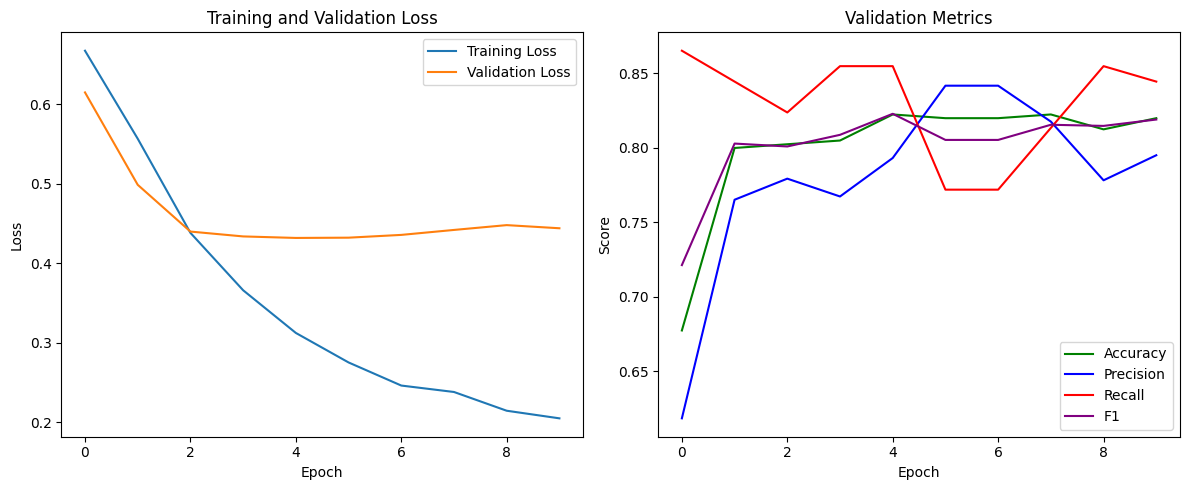

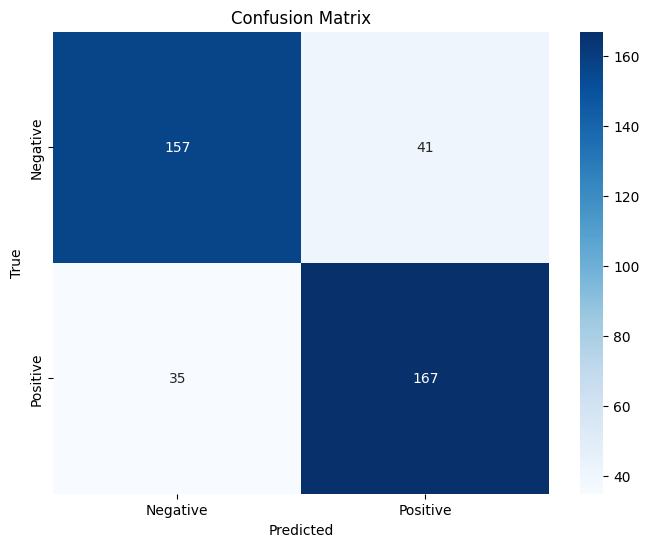


Example Inference:
Example 1: I am happy today.
Predicted sentiment: Positive (confidence: 0.8122)

Example 2: This is so sad.
Predicted sentiment: Negative (confidence: 0.8119)

Example 3: I’m really scared.
Predicted sentiment: Negative (confidence: 0.7489)

Example 4: That made me angry.
Predicted sentiment: Negative (confidence: 0.6757)

Example 5: Although I smiled, deep down I felt completely empty.
Predicted sentiment: Negative (confidence: 0.6995)

Example 6: I didn’t expect it, but I’m incredibly proud of myself.
Predicted sentiment: Positive (confidence: 0.9050)

Example 7: My hands were shaking as I waited for the results.
Predicted sentiment: Negative (confidence: 0.7360)

Example 8: I’m not unhappy, but I wouldn’t say I’m thrilled either.
Predicted sentiment: Negative (confidence: 0.6228)

Example 9: I can’t deny that I didn’t feel a bit of joy.
Predicted sentiment: Negative (confidence: 0.5952)

Example 10: She wasn’t exactly angry, yet something about her silence scream

In [56]:
if __name__ == "__main__":
    main()

In [32]:
train_df['label'][15295]

np.int64(1)